In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import warnings
import joblib
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [54]:
df = pd.read_csv('diamonds_train.csv')

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43018 entries, 0 to 43017
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43018 non-null  float64
 1   cut      43018 non-null  object 
 2   color    43018 non-null  object 
 3   clarity  43018 non-null  object 
 4   depth    43018 non-null  float64
 5   table    43018 non-null  float64
 6   price    43018 non-null  int64  
 7   x        43018 non-null  float64
 8   y        43018 non-null  float64
 9   z        43018 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.3+ MB


In [56]:
# Проверяем пропущенные значения
missing = df.isnull().sum()
display(missing[missing > 0] if missing.sum() > 0 else "Пропущенных значений нет")

# Проверяем категориальные переменные
categorical_cols = ['cut', 'color', 'clarity']
for col in categorical_cols:
    if col in df.columns:
        print(f"{col}: {sorted(df[col].unique())}")

# Кодируем категориальные переменные
label_encoders = {}
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col])
        label_encoders[col] = le

'Пропущенных значений нет'

cut: ['Fair', 'Good', 'Ideal', 'Premium', 'Very Good']
color: ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity: ['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2']


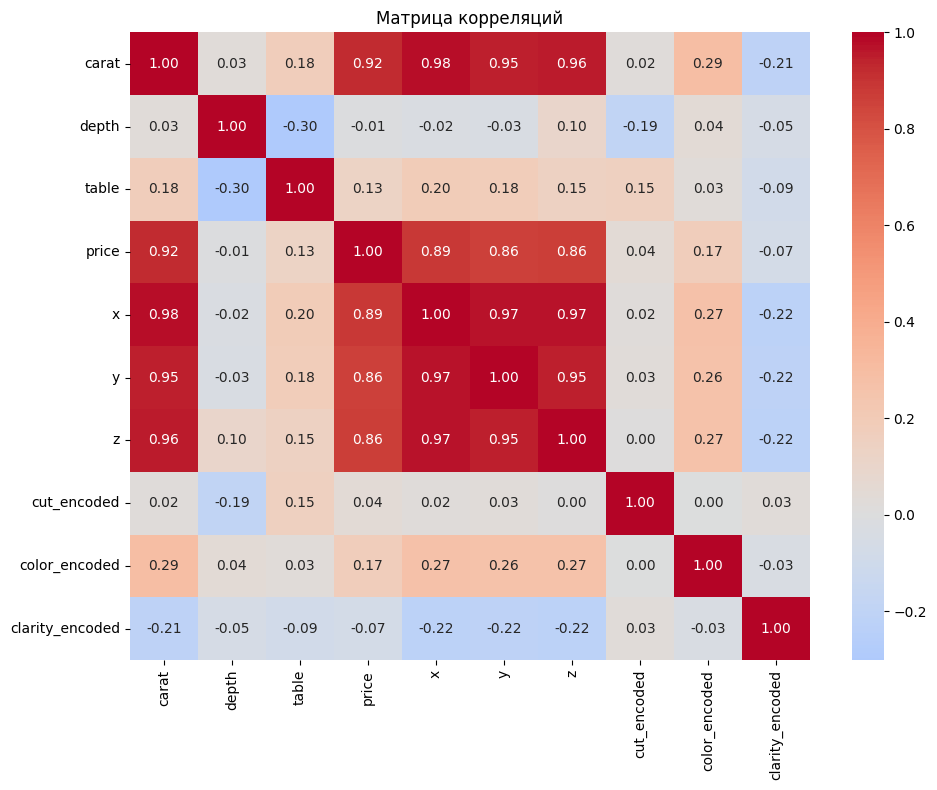

Корреляция с ценой:
price              1.000000
carat              0.922442
x                  0.886913
z                  0.864412
y                  0.862367
color_encoded      0.171917
table              0.125539
cut_encoded        0.041008
depth             -0.008988
clarity_encoded   -0.070129
Name: price, dtype: float64


In [57]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

print("Корреляция с ценой:")
print(correlation_matrix['price'].sort_values(ascending=False))

In [58]:
def create_features(data):
    df_eng = data.copy()

    # Базовые геометрические признаки
    df_eng['volume'] = df_eng['x'] * df_eng['y'] * df_eng['z']
    df_eng['surface_area'] = 2 * (df_eng['x']*df_eng['y'] + df_eng['x']*df_eng['z'] + df_eng['y']*df_eng['z'])
    df_eng['density'] = df_eng['carat'] / (df_eng['volume'] + 1e-8)  # защита от деления на 0

    # Пропорции и соотношения
    df_eng['table_ratio'] = df_eng['table'] / df_eng['depth']
    df_eng['depth_ratio'] = df_eng['depth'] / ((df_eng['x'] + df_eng['y'] + df_eng['z']) / 3)
    df_eng['size_ratio_xy'] = df_eng['x'] / (df_eng['y'] + 1e-8)
    df_eng['size_ratio_xz'] = df_eng['x'] / (df_eng['z'] + 1e-8)

    # Индексы формы
    df_eng['elongation'] = df_eng[['x', 'y', 'z']].max(axis=1) / df_eng[['x', 'y', 'z']].min(axis=1)
    df_eng['avg_size'] = (df_eng['x'] + df_eng['y'] + df_eng['z']) / 3

    # Взаимодействие карата с другими признаками
    df_eng['carat_per_volume'] = df_eng['carat'] / (df_eng['volume'] + 1e-8)
    df_eng['carat_squared'] = df_eng['carat'] ** 2
    df_eng['carat_log'] = np.log1p(df_eng['carat'])

    return df_eng

# Применяем создание признаков
df = create_features(df)
df_test = create_features(df_test)

print(f"После создания признаков: {df.shape}")

После создания признаков: (43018, 25)


In [59]:
print("Категориальные переменные:")
categorical_cols = ['cut', 'color', 'clarity']

# Порядковое кодирование на основе знаний о драгоценных камнях
cut_order = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
color_order = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
clarity_order = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}

for data in [df, df_test]:
    # Порядковое кодирование
    data['cut_ordered'] = data['cut'].map(cut_order)
    data['color_ordered'] = data['color'].map(color_order)
    data['clarity_ordered'] = data['clarity'].map(clarity_order)

    # Frequency encoding
    data['cut_freq'] = data['cut'].map(data['cut'].value_counts())
    data['color_freq'] = data['color'].map(data['color'].value_counts())
    data['clarity_freq'] = data['clarity'].map(data['clarity'].value_counts())

print("Категориальные переменные обработаны")

Категориальные переменные:
Категориальные переменные обработаны


In [60]:
exclude_cols = ['price', 'id', 'cut', 'color', 'clarity']
feature_columns = [col for col in df.columns if col not in exclude_cols]

print(f"Всего признаков: {len(feature_columns)}")
print("Признаки:", feature_columns)

X = df[feature_columns]
y = df['price']

# Логарифмирование целевой переменной для лучшей стабильности
y_log = np.log1p(y)

print(f"Формы: X {X.shape}, y {y.shape}")

Всего признаков: 27
Признаки: ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_encoded', 'color_encoded', 'clarity_encoded', 'volume', 'surface_area', 'density', 'table_ratio', 'depth_ratio', 'size_ratio_xy', 'size_ratio_xz', 'elongation', 'avg_size', 'carat_per_volume', 'carat_squared', 'carat_log', 'cut_ordered', 'color_ordered', 'clarity_ordered', 'cut_freq', 'color_freq', 'clarity_freq']
Формы: X (43018, 27), y (43018,)


=== ОТБОР ПРИЗНАКОВ ===
Отобрано признаков: 20
Отобранные признаки: ['carat', 'table', 'x', 'y', 'z', 'color_encoded', 'volume', 'surface_area', 'density', 'table_ratio', 'depth_ratio', 'size_ratio_xy', 'avg_size', 'carat_per_volume', 'carat_squared', 'carat_log', 'color_ordered', 'clarity_ordered', 'color_freq', 'clarity_freq']


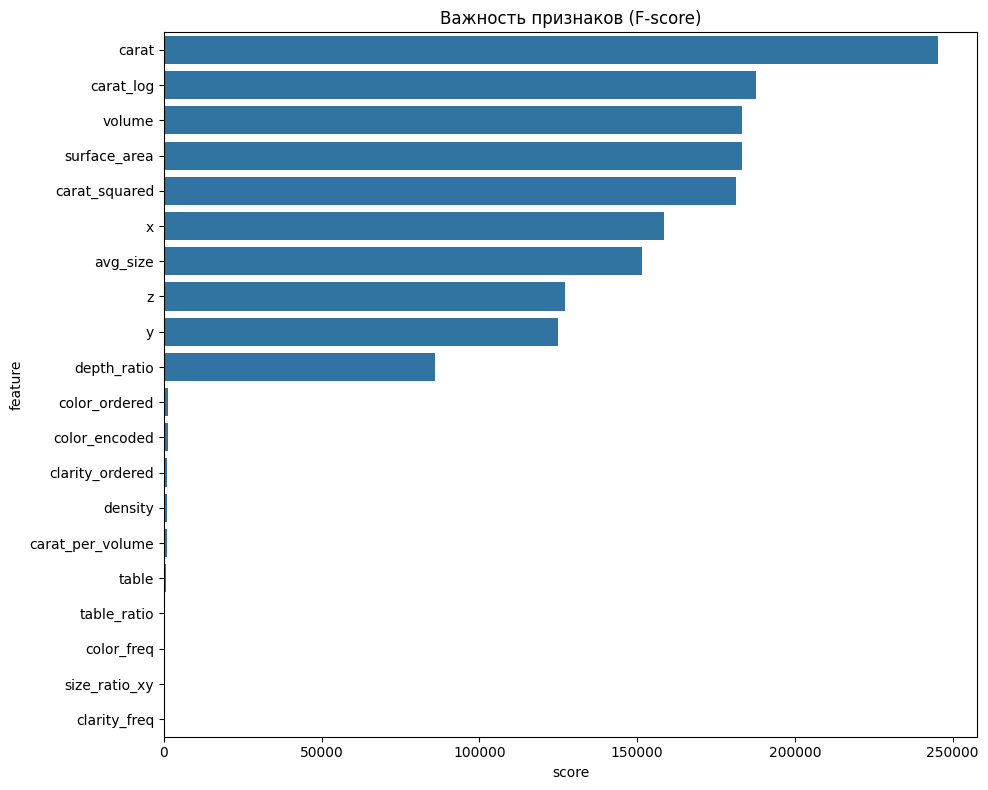

In [61]:
print("=== ОТБОР ПРИЗНАКОВ ===")

# Выбираем топ-20 признаков
selector = SelectKBest(score_func=f_regression, k=min(20, len(feature_columns)))
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print(f"Отобрано признаков: {len(selected_features)}")
print("Отобранные признаки:", list(selected_features))

X = X[selected_features]

# Анализ важности признаков
feature_scores = pd.DataFrame({
    'feature': selected_features,
    'score': selector.scores_[selector.get_support()]
}).sort_values('score', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_scores, x='score', y='feature')
plt.title('Важность признаков (F-score)')
plt.tight_layout()
plt.show()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Обучающая выборка: {X_train.shape[0]:,} samples")
print(f"Тестовая выборка: {X_test.shape[0]:,} samples")

Обучающая выборка: 34,414 samples
Тестовая выборка: 8,604 samples


In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Данные масштабированы")

Данные масштабированы


In [64]:
print("=== ТЕСТИРОВАНИЕ МОДЕЛЕЙ ===")

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nОбучение {name}...")
    model.fit(X_train_scaled, y_train)

    # Предсказания (возвращаем из логарифма)
    y_pred_train = np.expm1(model.predict(X_train_scaled))
    y_pred_test = np.expm1(model.predict(X_test_scaled))

    # Метрики на исходной шкале
    train_r2 = r2_score(np.expm1(y_train), y_pred_train)
    test_r2 = r2_score(np.expm1(y_test), y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(np.expm1(y_train), y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_test))

    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'overfitting': train_r2 - test_r2
    }

    print(f"{name}:")
    print(f"  R² - Train: {train_r2:.4f}, Test: {test_r2:.4f}")
    print(f"  RMSE - Train: ${train_rmse:,.2f}, Test: ${test_rmse:,.2f}")
    print(f"  Переобучение: {train_r2 - test_r2:.4f}")

=== ТЕСТИРОВАНИЕ МОДЕЛЕЙ ===

Обучение LinearRegression...
LinearRegression:
  R² - Train: 0.9403, Test: -9233729477721440312801162059272115317435350244867314206085847442958149556598156666591637805982090138845408058162754355200.0000
  RMSE - Train: $971.84, Test: $12,215,618,884,733,259,205,470,981,285,044,286,131,901,793,586,516,199,364,771,184,640.00
  Переобучение: 9233729477721440312801162059272115317435350244867314206085847442958149556598156666591637805982090138845408058162754355200.0000

Обучение RandomForest...
RandomForest:
  R² - Train: 0.9973, Test: 0.9780
  RMSE - Train: $205.98, Test: $595.93
  Переобучение: 0.0193

Обучение GradientBoosting...
GradientBoosting:
  R² - Train: 0.9774, Test: 0.9753
  RMSE - Train: $597.78, Test: $631.67
  Переобучение: 0.0021


In [67]:
print("\n=== НАСТРОЙКА ЛУЧШЕЙ МОДЕЛИ ===")

# Выбираем модель с лучшим test R²
best_model_name = max(results.keys(), key=lambda x: results[x]['test_r2'])
best_score = results[best_model_name]['test_r2']

print(f"Лучшая модель: {best_model_name} (R² = {best_score:.4f})")

if best_model_name == 'RandomForest':
    param_grid = {
        'n_estimators': [100],
        'max_depth': [15, 20],
    }
    base_model = RandomForestRegressor(random_state=42, n_jobs=-1)

else:
    param_grid = {
        'n_estimators': [100],
        'max_depth': [4],
        'learning_rate': [0.1]
    }
    base_model = GradientBoostingRegressor(random_state=42)

print("Быстрая настройка гиперпараметров...")

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    base_model, param_grid,
    n_iter=2,  # всего 2 комбинации
    cv=2,      # 2-fold CV для скорости
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=0   # убираем вывод
)

random_search.fit(X_train_scaled, y_train)

print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_




=== НАСТРОЙКА ЛУЧШЕЙ МОДЕЛИ ===
Лучшая модель: RandomForest (R² = 0.9780)
Быстрая настройка гиперпараметров...
Лучшие параметры: {'n_estimators': 100, 'max_depth': 20}
Лучший score: 0.9914


In [68]:
print("\n=== ОЦЕНКА ФИНАЛЬНОЙ МОДЕЛИ ===")

# Предсказания финальной модели
y_pred_train_final = np.expm1(final_model.predict(X_train_scaled))
y_pred_test_final = np.expm1(final_model.predict(X_test_scaled))

# Метрики
final_train_r2 = r2_score(np.expm1(y_train), y_pred_train_final)
final_test_r2 = r2_score(np.expm1(y_test), y_pred_test_final)
final_train_rmse = np.sqrt(mean_squared_error(np.expm1(y_train), y_pred_train_final))
final_test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_test_final))

print("ФИНАЛЬНЫЕ МЕТРИКИ:")
print(f"R² - Train: {final_train_r2:.4f}, Test: {final_test_r2:.4f}")
print(f"RMSE - Train: ${final_train_rmse:,.2f}, Test: ${final_test_rmse:,.2f}")
print(f"Переобучение: {final_train_r2 - final_test_r2:.4f}")




=== ОЦЕНКА ФИНАЛЬНОЙ МОДЕЛИ ===
ФИНАЛЬНЫЕ МЕТРИКИ:
R² - Train: 0.9971, Test: 0.9780
RMSE - Train: $213.31, Test: $596.55
Переобучение: 0.0191


In [69]:
print("\n=== ФИНАЛЬНОЕ ОБУЧЕНИЕ НА ВСЕХ ДАННЫХ ===")

# Масштабирование всех данных
X_full_scaled = scaler.fit_transform(X)

# Обучение финальной модели на всех данных
final_model.fit(X_full_scaled, y_log)

# Оценка на всех данных
y_full_pred = np.expm1(final_model.predict(X_full_scaled))
full_r2 = r2_score(y, y_full_pred)
full_rmse = np.sqrt(mean_squared_error(y, y_full_pred))

print(f"Финальные метрики на всех данных:")
print(f"R²: {full_r2:.4f}")
print(f"RMSE: ${full_rmse:,.2f}")


=== ФИНАЛЬНОЕ ОБУЧЕНИЕ НА ВСЕХ ДАННЫХ ===
Финальные метрики на всех данных:
R²: 0.9970
RMSE: $218.38


In [70]:
print("\n=== ПРЕДСКАЗАНИЕ НА ТЕСТОВЫХ ДАННЫХ ===")

# Подготовка тестовых данных
X_test_comp = df_test[selected_features].fillna(0)

# Масштабирование
X_test_comp_scaled = scaler.transform(X_test_comp)

# Предсказание
test_predictions = np.expm1(final_model.predict(X_test_comp_scaled))

# Создание submission файла
submission = pd.DataFrame({
    'id': df_test['id'],
    'price': test_predictions
})

# Убеждаемся, что цены неотрицательные
submission['price'] = submission['price'].clip(lower=0)

# Сохранение
submission.to_csv('submission.csv', index=False)

print(f"Статистика предсказаний:")
print(f"Min: ${submission['price'].min():.2f}")
print(f"Max: ${submission['price'].max():.2f}")
print(f"Mean: ${submission['price'].mean():.2f}")
print(f"Median: ${submission['price'].median():.2f}")

joblib.dump(final_model, 'final_diamond_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')




=== ПРЕДСКАЗАНИЕ НА ТЕСТОВЫХ ДАННЫХ ===
Статистика предсказаний:
Min: $379.66
Max: $18058.65
Mean: $3809.49
Median: $2436.04


['selected_features.pkl']